<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-GIA-model-weights-(LIG-+-Holocene)" data-toc-modified-id="Load-GIA-model-weights-(LIG-+-Holocene)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load GIA model weights (LIG + Holocene)</a></span></li></ul></div>

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from pathlib import Path
PROJECT_ROOT = Path.cwd().parents[1]

import sys
sys.path.append(str(PROJECT_ROOT))
from bahamas_lig.utils import *
import matplotlib.gridspec as gridspec

### Load GIA model weights (LIG + Holocene)

In [13]:
hol_model_dir = PROJECT_ROOT / "model_outputs/get_GIA/output_Hol_new"
hol_inference_dir = PROJECT_ROOT / "model_outputs/holocene"
lig_model_dir = PROJECT_ROOT / "model_outputs/get_GIA/output_new"
lig_inference_dir = PROJECT_ROOT / "model_outputs/"
# data_dir = PROJECT_ROOT / "data/"

holocene_dataframe = get_model_status(hol_inference_dir,hol_model_dir)
lig_dataframe = get_model_status(lig_inference_dir,lig_model_dir)

# holocene_dataframe = pd.read_csv('/limestone/jupyter/blake/bahamas-gia/data/processed/BMA_weighted_models_holocene.csv', index_col=0)

In [14]:
lig_predict_dir = str(lig_inference_dir)+'/'+str('pymc3_post_predict_2021')
lig_predict_list=[o[:-4] for o in os.listdir(lig_predict_dir) if '.pkl' in o]

In [15]:
preds = {}
for f in lig_predict_list:
    preds[f]=load(lig_predict_dir+'/'+f+'.pkl')

In [16]:
combined_weight = lig_dataframe.copy()
X_new = np.linspace(115, 130, 200)[:, np.newaxis]
# Uncomment through line 8 to include holocene weights

# for i in range(len(holocene_dataframe)):
#     ids=((lig_dataframe['LMV']==holocene_dataframe['LMV'][i]) & (lig_dataframe['UMV']==holocene_dataframe['UMV'][i]) & (lig_dataframe['Lithosphere']==holocene_dataframe['Lithosphere'][i]))
#     combined_weight.at[ids,'weight']=combined_weight[ids]['weight'].values*holocene_dataframe['weight'].values[i]
# combined_weight['weight'] = combined_weight['weight']/np.sum(combined_weight['weight'].values)

# Example of disabling certain ice histories
# combined_weight['weight'][combined_weight['ice_history']!='ICE6G']=0
# combined_weight['weight'] = combined_weight['weight']/np.sum(combined_weight['weight'].values)
# combined_weight['weight']=1/576

gmsl=weighted_trace(preds,combined_weight,iters=10000)
## Can use this line to recode the regional-wide subsidence added to the data. 
## Here I remove the flat 2.5 and add 0.023 m per ky and some extra white noise (mu=0,sigma=0.4)
gmsl = gmsl - 2.5 + np.tile(X_new,gmsl.shape[0]).T*.023+np.random.normal(0,.4,gmsl.shape)


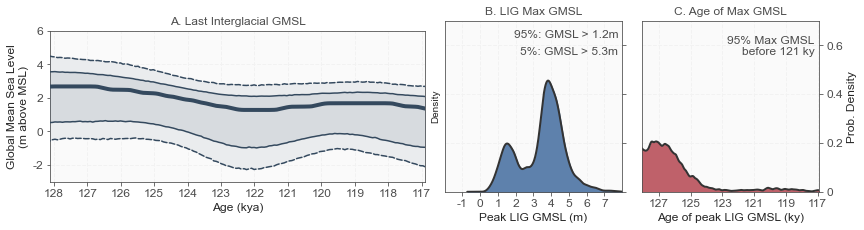

In [17]:
##Calculations
# gmsl=inferences[0]
inferences=[gmsl]

gmsl=np.array([g for g in gmsl if not all(np.isnan(g))])
peak_gmsl=np.nanmax(gmsl,axis=1)
#remove allnan slices
# gmsl=gmsl[:,LIG_ONLY]
maxes=np.argmax(gmsl,axis=1)
A=X_new.ravel()[maxes]
bandwidth_for_kde=0.1
f_size=12

sns.set_style(
    "ticks",
    {
        "axes.edgecolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "axes.facecolor": "(.98,.98,.98)",
        "axes.grid": True,
        "grid.color": ".95",
        "grid.linestyle": u"--",
    },
)
flatui = ["#D08770", "#BF616A", "#A3BE8C", "#B48EAD", "#34495e", "#5E81AC"]
cs = sns.color_palette(flatui)


##Figure
fig = plt.figure(figsize=(11*1.1,3*1.1))
gs = gridspec.GridSpec(1, 4)
ax1=fig.add_subplot(gs[0, :2])

plot_gmsl_inference(X_new,inferences[0],cs[4],ax1,plot_max_like=True)
plt.gca().set_title(
    "A. Last Interglacial GMSL",
    fontsize=f_size,
)
ax1.set_aspect(1/2)
ax1.set_ylim([-3, 6])
ax1.set_yticks([-2,0,2,4,6])
ax1.set_yticklabels([-2,0,2,4,6],fontsize=f_size)
ax1.set_xlim([116.9,128.1])
ax1.invert_xaxis()
ax1.set_xticks(np.arange(128,116,-1))
ax1.set_xticklabels(np.arange(128,116,-1),fontsize=f_size)


ax1.set_ylabel("Global Mean Sea Level\n(m above MSL)", fontsize=f_size)
ax1.set_xlabel("Age (kya)",fontsize=f_size)
ax1.grid(True,linewidth=1)

ax2=fig.add_subplot(gs[:, 2])
sns.kdeplot(peak_gmsl, gridsize=1000, bw_method=bandwidth_for_kde, shade=True, color=cs[5], lw=1,alpha=1)
sns.kdeplot(peak_gmsl,  bw_method=bandwidth_for_kde, gridsize=1000, shade=False, color=(.2,.2,.2), lw=2,alpha=1)
ax2.set_xlim([-2, 8])
ax2.set_xticks(np.arange(-1, 8,1))
ax2.set_xticklabels(np.arange(-1, 8,1),fontsize=f_size)
ax2.set_ylim([0,.7])
ax2.set_yticks([0,.2,.4,.6])
ax2.set_yticklabels([],fontsize=f_size)
ax2.set_xlabel("Peak LIG GMSL (m)", fontsize=f_size)


ax2_twin = plt.gca().twinx()
ax2_twin.set_ylim([0, 1])

ax2.set_title(
    "B. LIG Max GMSL",
    fontsize=f_size,
)

ax2_twin.text(
    7.8,
    0.9,
    "95%: GMSL > " + str(np.round(np.nanpercentile(peak_gmsl, 5), 1)) +"m",horizontalalignment='right',
    fontsize=f_size,
)
ax2_twin.text(
    7.8,
    0.8,
    "5%: GMSL > " + str(np.round(np.nanpercentile(peak_gmsl, 95), 1)) +"m",horizontalalignment='right',
    fontsize=f_size,
)
ax2_twin.axis("off")
ax2.yaxis.tick_right()
ax2.grid(True,linewidth=1)

ax3=fig.add_subplot(gs[:, 3])
sns.kdeplot(A,  bw_method=bandwidth_for_kde/3, gridsize=1000, shade=True, color=cs[1], lw=0,alpha=1)
sns.kdeplot(A,  bw_method=bandwidth_for_kde/3, gridsize=1000, shade=False, color=(.2,.2,.2), lw=2,alpha=1)
ax3.set_xlim([116.9,128.1])
ax3.set_xlabel("Age of peak LIG GMSL (ky)", fontsize=f_size)
ax3.set_ylabel("Prob. Density", fontsize=f_size)
ax3.set_ylim([0,.7])
ax3.set_yticks([0,.2,.4,.6])
ax3.set_yticklabels([0,.2,.4,.6],fontsize=f_size)

ax3.invert_xaxis()
ax3.set_title(
    "C. Age of Max GMSL",
    fontsize=f_size,
)

ax3.set_xticks(np.arange(127,116,-2))
ax3.set_xticklabels(np.arange(127,116,-2),fontsize=f_size)

ax3_twin = plt.gca().twinx()
ax3_twin.set_ylim([0, 1])

pct=np.round(np.sum(A>121)/A.size*100).astype(int)
ax3_twin.text(
    117.2,
    0.8,
    str(pct)+"% Max GMSL\nbefore 121 ky",horizontalalignment='right',
    fontsize=f_size,
)
ax3_twin.axis("off")
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.grid(True,linewidth=1)

fig.tight_layout(w_pad=0,h_pad=0)
fig.savefig("GMSL_curve.pdf", bbox_inches="tight", dpi=300)

**Fig. 6.** GMSL estimates for the LIG derived from analysis that includes a probabilistic assessment of 576 GIA models, previously published Bahamian archipelago corals ,andthe peak local sea level observations reported in this paper. Panel A shows inferred GMSL change throughout the LIG. Panel B shows the distribution of maximum GMSL (atany point during the LIG), and Panel C shows distribution in time for peak GMSL.

Below you will find some calculations about oscillations within the LIG:

In [18]:
from scipy.ndimage import gaussian_filter

In [19]:
N=0
osc=[]
for N in range(10000):
    filter_size = 10
    signal = gaussian_filter(gmsl[N,:],filter_size)
    gradient = np.gradient(signal)

    zero_crossings = np.where(np.diff(np.sign(gradient)))[0]
    if zero_crossings.size>1:
        min_osc = np.argmin(signal[zero_crossings])
        if min_osc>0:
            lo = signal[zero_crossings[min_osc]]
            hi = np.max(signal[zero_crossings[:min_osc]])
            osc.append(hi-lo)
        else:
            osc.append(0)
    else:
        osc.append(0)


The 2.5 and 97.5 percentile oscillation magnitude:

In [20]:
print(np.percentile(osc,2.5),np.percentile(osc,97.5))

0.0 1.8219041474065625


<AxesSubplot:ylabel='Density'>

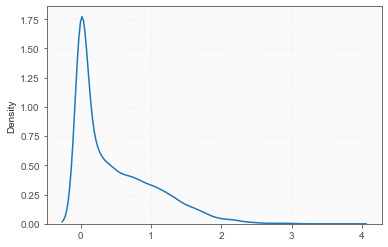

In [21]:
sns.kdeplot(osc)

Density plot of the within LIG oscillation magnitude.

In [22]:
np.mean(osc)

0.4877309851499181